In [5]:
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
##############################################################################

In [5]:
# load CIFAR-10

In [6]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [7]:
Xtr, Ytr, Xte, Yte = load_CIFAR10('./cifar-10-batches-py/')

#reshape
Xtr = Xtr.reshape(Xtr.shape[0],32 * 32 * 3)
Xte = Xte.reshape(Xte.shape[0],32 * 32 * 3)

In [ ]:
##############################################################################

In [ ]:
# KNN

In [ ]:
import operator as oprt
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y
    
    def predict(self, X, K = 1):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # lets make sure that the output type matches the input type
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)
        #import pdb;pdb.set_trace()
        # loop over all test rows
        for i in xrange(num_test):
            print i
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            if K == 1:
                min_index = np.argmin(distances)
                Ypred[i] = self.ytr[min_index]
            else :

                sort_dist_idx = np.argsort(distances)
                knn_labels = self.ytr[sort_dist_idx[0:K]]
                Ypred[i] = pd.Series(knn_labels).value_counts().index[0]
        return Ypred

nn = NearestNeighbor()
nn.train(Xtr_rows, Ytr)

m = 100
Ypred = nn.predict(Xte_rows[0:m], K = 3)
#print Ypred[0:m], Yte[0:m]
print np.sum(Ypred == Yte[0:m])

In [ ]:
##############################################################################

In [66]:
# multi-class SVM

In [8]:
num_train = 49000
num_val = 1000
num_dev = 1000  #从49000中选
num_test = 1000 #从

#perprocessing : 
X_train = Xtr[np.arange(num_train)]
y_train = Ytr[np.arange(num_train)]

X_val = Xtr[np.arange(num_train, Xtr.shape[0])]
y_val = Ytr[np.arange(num_train, Xtr.shape[0])]

mask = np.random.choice(num_train, num_dev)
X_dev = Xtr[mask]
y_dev = Ytr[mask]

X_test = Xte[np.arange(num_test)]
y_test = Yte[np.arange(num_test)]

In [9]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val   -= mean_image
X_dev   -= mean_image
X_test  -= mean_image

In [10]:
X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1)) ), axis = 1)
X_val   = np.concatenate((X_val,   np.ones((X_val.shape[0],   1)) ), axis = 1)
X_dev   = np.concatenate((X_dev,   np.ones((X_dev.shape[0],   1)) ), axis = 1)
X_test  = np.concatenate((X_test,  np.ones((X_test.shape[0],  1)) ), axis = 1)

In [33]:
class SVM(object):
    def __init__(self):
        pass

    def train(self, X, y, num_iters=100, batch_size=100, eta=1e-4, reg=1e-5, verbose=True):
        
        num_train, dimension = X.shape
        
        labels = np.unique(y)         #不用对 y 进行one-hot编码
        num_labels = labels.shape[0]

        self.w = np.random.rand(num_labels, dimension) * 0.001 # k * (d+1)
        
        for i in range(num_iters):
            indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[indices]
            y_batch = y[indices]
            loss, dW = self.SGD(X_batch, y_batch, reg)
            self.w += -eta * dW

            if verbose and i % 100 == 0:
                print "{0} iter, training loss: {1}, trainging accuracy: {2}".format(i, \
                       loss, self.evaluate(X, y))

    def SGD(self, X_batch, y_batch, reg):
        loss = 0
        dW = np.zeros(self.w.shape, self.w.dtype)
        
        bat_size = X_batch.shape[0]
        
        scores = np.dot(self.w, X_batch.T)  #k * (d+1) * (d+1)*batch_size = k * batch_size
        margins = np.maximum(0, scores - scores[y_batch, np.arange(bat_size)] + 1) 
        margins[y_batch, np.arange(bat_size)] = 0
        loss = np.sum(margins) / bat_size
        loss += reg * np.sum(self.w * self.w)
        
        indicator = (margins > 0).astype('float64')
        indicator[y_batch, np.arange(bat_size)] = -np.sum(indicator, axis = 0)  
        dW = np.dot(indicator, X_batch)
        dW /= num_train
        dW += 2 * reg * self.w

        return loss, dW
    
    def evaluate(self, X, y):
        scores = np.dot(self.w, X.T)
        ypred = np.argmax(scores, axis = 0)
        return np.mean(ypred == y)
    
    def predict(self, X):
        scores = np.dot(self.w, X.T)
        ypred = np.argmax(scores, axis = 0)
        return ypred


    
#所有用于训练的数据，其预处理一律在外部进行，分类器只管训练，
svm = SVM()
m = 10000
svm.train(X_train[0:m], y_train[0:m], \
          num_iters = 2000, batch_size = 1000, eta = 1e-7, reg=2.5e4,verbose=True)

0 iter, training loss: 265.60955705, trainging accuracy: 0.1374
100 iter, training loss: 102.120256031, trainging accuracy: 0.1538
200 iter, training loss: 41.9946860964, trainging accuracy: 0.1963
300 iter, training loss: 20.0468175851, trainging accuracy: 0.2395
400 iter, training loss: 11.7128180867, trainging accuracy: 0.2632
500 iter, training loss: 8.84323122723, trainging accuracy: 0.2736
600 iter, training loss: 7.56234052219, trainging accuracy: 0.2775
700 iter, training loss: 7.34596828019, trainging accuracy: 0.277
800 iter, training loss: 6.93132515324, trainging accuracy: 0.2786
900 iter, training loss: 7.01098664077, trainging accuracy: 0.2789
1000 iter, training loss: 6.97714797935, trainging accuracy: 0.2809
1100 iter, training loss: 7.02928113022, trainging accuracy: 0.2802
1200 iter, training loss: 6.88085121029, trainging accuracy: 0.281
1300 iter, training loss: 7.04440283114, trainging accuracy: 0.2813
1400 iter, training loss: 7.01351700021, trainging accuracy: 0.

In [2]:
######################################################################################################

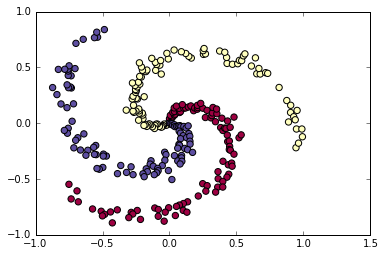

In [6]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [9]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(200):

    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print "iteration %d: loss %f" % (i, loss)

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dW += reg*W # regularization gradient

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.100747
iteration 10: loss 0.906267
iteration 20: loss 0.833506
iteration 30: loss 0.800117
iteration 40: loss 0.782540
iteration 50: loss 0.772412
iteration 60: loss 0.766201
iteration 70: loss 0.762216
iteration 80: loss 0.759571
iteration 90: loss 0.757770
iteration 100: loss 0.756517
iteration 110: loss 0.755631
iteration 120: loss 0.754996
iteration 130: loss 0.754536
iteration 140: loss 0.754200
iteration 150: loss 0.753951
iteration 160: loss 0.753767
iteration 170: loss 0.753630
iteration 180: loss 0.753527
iteration 190: loss 0.753449


In [10]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.51


(274, 287) (274, 287) (78638,)


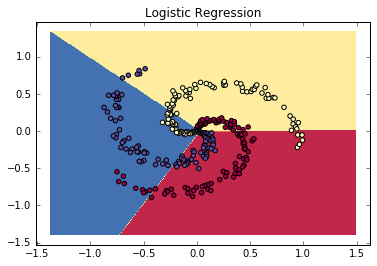

In [32]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
   
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    print xx.shape, yy.shape, Z.shape

    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

def predict(x):
    scores = np.dot(x,W) + b
    predicted_class = np.argmax(scores, axis=1)
    return predicted_class

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Logistic Regression")

In [36]:
import sys
sys.path.append('./assignment1/cs231n/classifiers/')
import neural_net

In [78]:
print X.shape, y.shape

(300, 2) (300,)


In [86]:
nn = neural_net.TwoLayerNet(2, 100, 3, std = 0.01)
_ = nn.train(X, y, X, y, num_iters=10000, verbose=True, learning_rate=0.5, reg=1, batch_size=300, learning_rate_decay=1)

1
iteration 0 / 10000: loss 1.147627
iteration 100 / 10000: loss 1.098730
iteration 200 / 10000: loss 1.097706
iteration 300 / 10000: loss 1.102136
iteration 400 / 10000: loss 1.099269
iteration 500 / 10000: loss 1.099204
iteration 600 / 10000: loss 1.098410
iteration 700 / 10000: loss 1.100031
iteration 800 / 10000: loss 1.098167
iteration 900 / 10000: loss 1.097808
iteration 1000 / 10000: loss 1.098859
iteration 1100 / 10000: loss 1.098525
iteration 1200 / 10000: loss 1.098110
iteration 1300 / 10000: loss 1.097286
iteration 1400 / 10000: loss 1.099341
iteration 1500 / 10000: loss 1.098377
iteration 1600 / 10000: loss 1.096630
iteration 1700 / 10000: loss 1.098799
iteration 1800 / 10000: loss 1.099241
iteration 1900 / 10000: loss 1.098771
iteration 2000 / 10000: loss 1.099807
iteration 2100 / 10000: loss 1.100467


KeyboardInterrupt: 

(274, 287) (274, 287) (78638,)


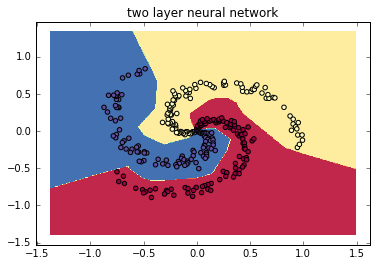

In [84]:
plot_decision_boundary(lambda x: nn.predict(x))
plt.title("two layer neural network")

In [72]:
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(10000):

    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 1.098667
iteration 1000: loss 0.414701
iteration 2000: loss 0.284930
iteration 3000: loss 0.248392
iteration 4000: loss 0.242434
iteration 5000: loss 0.240785
iteration 6000: loss 0.240159
iteration 7000: loss 0.239721
iteration 8000: loss 0.239427
iteration 9000: loss 0.239263


(274, 287) (274, 287) (78638,)


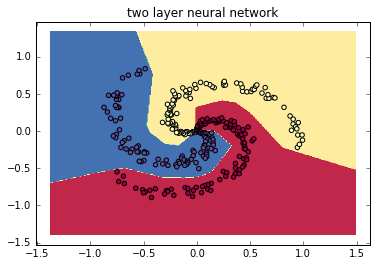

In [74]:
def predict(x):
    hidden_layer = np.maximum(0, np.dot(x, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
    return np.argmax(scores, axis=1)
plot_decision_boundary(lambda x: predict(x))
plt.title("two layer neural network")

In [ ]:
Yte.dtype

In [ ]:
np.random.rand(10)

In [13]:
a = np.array([[1,1,1],[2,2,2]])
a - np.mean(a, axis = 0)

array([[-0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5]])

In [14]:
np.concatenate((a, np.ones((np.array(a).shape[0],1))), axis = 1)

array([[ 1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  1.]])

In [ ]:
np.array([1]*np.array(a).shape[0]).T

In [9]:
b = np.array([[2,1],[3,7],[4,2]])
a = b.T

In [15]:
b

array([[2, 1],
       [3, 7],
       [4, 2]])

In [19]:
b[[0,1,2],[1,0,1]]

array([1, 3, 2])

In [20]:
b[:,[1,0,1]]

array([[1, 2, 1],
       [7, 3, 7],
       [2, 4, 2]])

In [27]:
a

array([[2, 3, 4],
       [1, 7, 2]])

In [44]:
a - np.mean(a, axis = 0)

array([[ 0.5, -2. ,  1. ],
       [-0.5,  2. , -1. ]])

In [43]:
np.maximum(0, a - np.mean(a, axis = 0))

array([[ 0.5,  0. ,  1. ],
       [ 0. ,  2. ,  0. ]])

In [34]:
a

array([[2, 3, 4],
       [1, 7, 2]])

In [35]:
a.mean(axis = 1)

array([ 3.        ,  3.33333333])

In [36]:
a.mean(axis = 1).reshape((2,1))

array([[ 3.        ],
       [ 3.33333333]])

In [33]:
a - a.mean(axis = 1).reshape((2,1))

array([[-1.        ,  0.        ,  1.        ],
       [-2.33333333,  3.66666667, -1.33333333]])

In [39]:
a[range(a.shape[0]), [2,1]]

array([4, 7])

In [41]:
a - a[range(a.shape[0]), [2,1]].reshape((2,1))

array([[-2, -1,  0],
       [-6,  0, -5]])

In [21]:
a - b[range(b.shape[0]), [1,0,1]]

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

In [14]:
b[[0,2],[1,1]]

array([1, 2])

In [20]:
a = np.concatenate((a,a))

In [3]:
b = np.array([0,1,2,3])

In [4]:
np.delete(b, 2)

array([0, 1, 3])

In [45]:
a

array([[4, 5, 6],
       [2, 8, 3],
       [3, 4, 5],
       [3, 9, 4]])

In [57]:
a[b!=2] += np.array([1,2,3])
a

array([[15, 17, 19],
       [13, 20, 16],
       [ 3,  4,  5],
       [14, 21, 17]])

In [56]:
a

array([[14, 15, 16],
       [12, 18, 13],
       [ 3,  4,  5],
       [13, 19, 14]])

In [47]:
b = a[b!=2] + 10

In [48]:
b

array([[14, 15, 16],
       [12, 18, 13],
       [13, 19, 14]])

In [17]:
a[:, [True, False, True]]

/home/lilinhan/workspace/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([[3, 2, 3],
       [7, 1, 7]])

In [ ]:
c = np.dot(a,b)

In [ ]:
np.argmax(c, axis = 0)

In [ ]:
np.random.shuffle(a)

In [ ]:
a = np.array([[1,2,3],[3,4,5]]).T

In [ ]:
np.zeros(a.shape)

In [ ]:
b

In [12]:
a 

NameError: name 'a' is not defined

In [ ]:
pd.DataFrame(a)

In [ ]:
a[:, [1,2,3]]

In [ ]:
(a > 2) * 2

In [ ]:
np.maximum(0, a[:,0] - a[2,0]+1)

In [ ]:
a

In [ ]:
a[b]